In [33]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Load the CSV file into a DataFrame
df_unemployment = pd.read_csv('UnemploymentRate_InSample.csv')

# Display the first few rows of the DataFrame to understand its structure
df_unemployment.head()

,Date,Unemployment Rate
0,1/02/1978,6.1881
1,1/03/1978,5.3346
2,1/04/1978,5.1547
3,1/05/1978,5.1390
4,1/06/1978,5.2859


In [34]:
# 1. Check for missing values
missing_values = df_unemployment.isnull().sum()

# 2. Basic statistics for the unemployment rate
basic_stats = df_unemployment['Unemployment Rate'].describe()

# Display the results
missing_values, basic_stats


(Date                 0
 Unemployment Rate    0
 dtype: int64,
 count    479.000000
 mean       6.749459
 std        1.972212
 min        3.499200
 25%        5.288950
 50%        6.137100
 75%        8.057250
 max       12.695800
 Name: Unemployment Rate, dtype: float64)

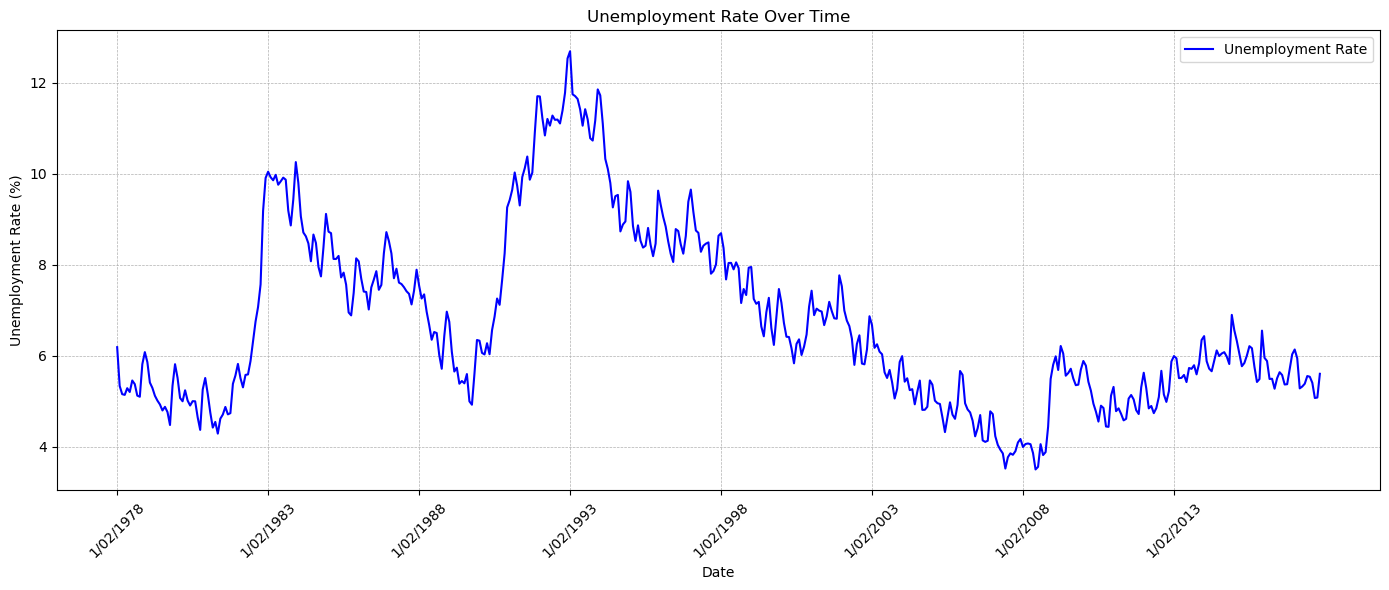

In [35]:
import matplotlib.pyplot as plt

# Visualizing the unemployment rate over time
plt.figure(figsize=(14, 6))
plt.plot(df_unemployment['Date'], df_unemployment['Unemployment Rate'], label='Unemployment Rate', color='blue')
plt.title('Unemployment Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.xticks(df_unemployment['Date'][::60], rotation=45)  # Show every 60th date for clarity
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [36]:
# Convert the 'Date' column to datetime format
df_unemployment['Date'] = pd.to_datetime(df_unemployment['Date'])

# Set the 'Date' column as the index
df_unemployment.set_index('Date', inplace=True)

In [37]:
from statsmodels.tsa.stattools import adfuller

# Perform Dickey-Fuller test
result = adfuller(df_unemployment['Unemployment Rate'])

# Extract results
test_statistic = result[0]
p_value = result[1]

test_statistic, p_value

(-1.8926760638731088, 0.33551432678740584)

The high p-value (greater than 0.05) suggests that we cannot reject the null hypothesis (The null hypothesis of this test is that the time series is not stationary). The unemployment rate time series is not stationary based on the Dickey-Fuller test.

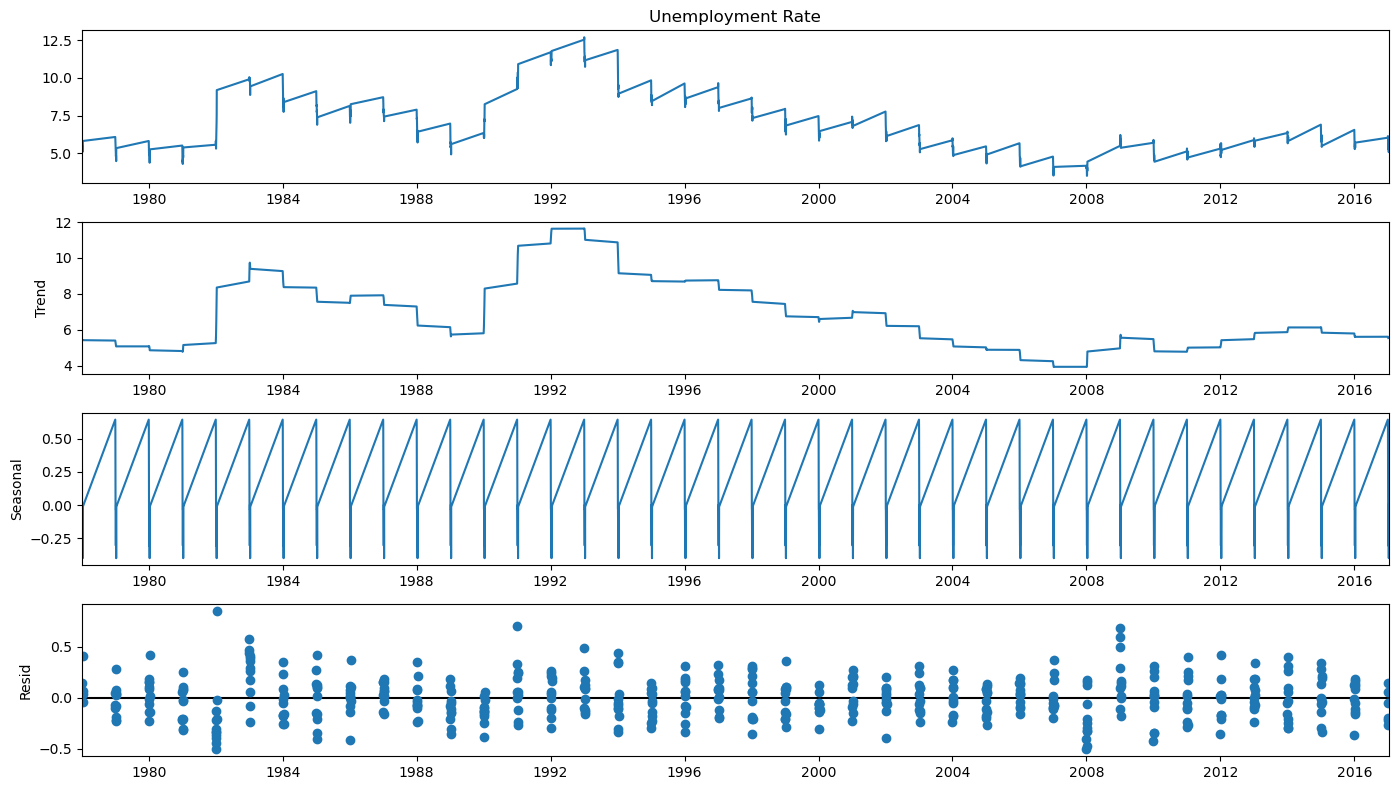

In [38]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Decompose the time series using the correct argument
decomposition = seasonal_decompose(df_unemployment['Unemployment Rate'], model='additive', period=12)

# Plotting the decomposition components
fig = decomposition.plot()
fig.set_size_inches(14, 8)
plt.tight_layout()
plt.show()

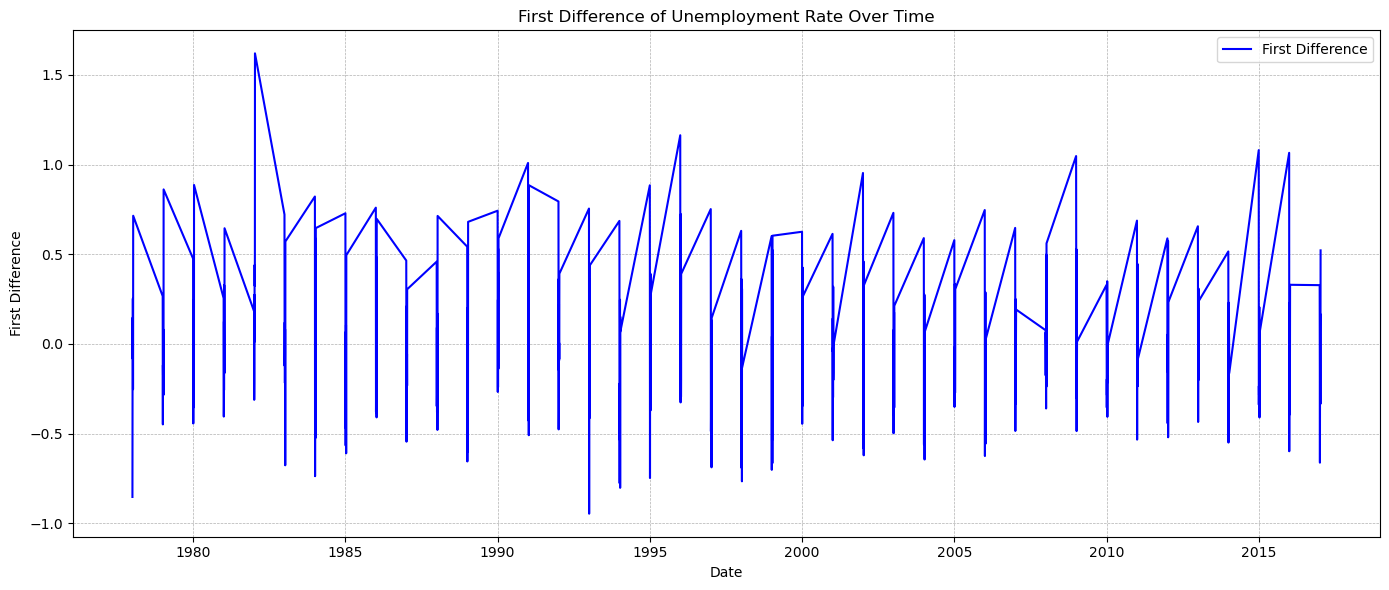

(-6.0190909779185295, 1.5087647362720447e-07)

In [39]:
# Take the first difference
df_unemployment['First Difference'] = df_unemployment['Unemployment Rate'].diff()

# Drop NaN values introduced by differencing
df_unemployment.dropna(inplace=True)

# Plot the first difference
plt.figure(figsize=(14, 6))
plt.plot(df_unemployment['First Difference'], label='First Difference', color='blue')
plt.title('First Difference of Unemployment Rate Over Time')
plt.xlabel('Date')
plt.ylabel('First Difference')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# Perform Dickey-Fuller test on the first difference
result_diff = adfuller(df_unemployment['First Difference'])
test_statistic_diff = result_diff[0]
p_value_diff = result_diff[1]

test_statistic_diff, p_value_diff


Given that the test statistic is less than the critical values and the p-value is significantly small, we can reject the null hypothesis. The first difference of the unemployment rate is stationary.

## Modeling 

###  Holt-Winters Exponential Smoothing

Exponential Smoothing is a time series forecasting method that uses a weighted average of past observations as a prediction. The Holt-Winters Exponential Smoothing technique allows for the modeling of series with trend and seasonality

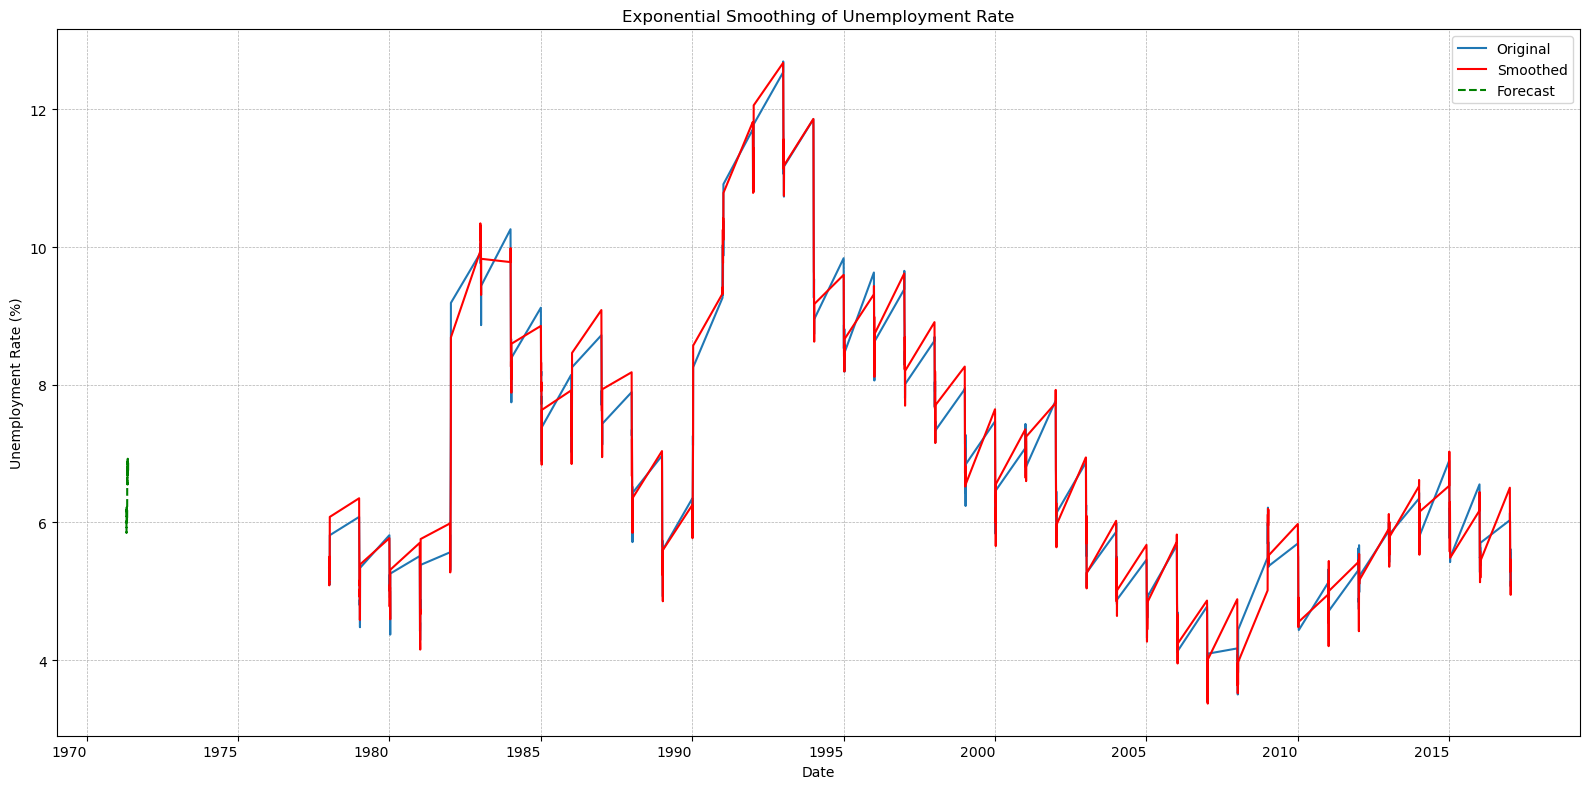

In [40]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit the Exponential Smoothing model
model = ExponentialSmoothing(df_unemployment['Unemployment Rate'], trend='additive', seasonal='additive', seasonal_periods=12)
fit = model.fit()

# Forecast the next 24 months
forecast = fit.forecast(steps=24)

# Plot the original series, smoothed series, and forecast
plt.figure(figsize=(16, 8))
df_unemployment['Unemployment Rate'].plot(label='Original', legend=True)
fit.fittedvalues.plot(label='Smoothed', legend=True, color='red')
forecast.plot(label='Forecast', legend=True, color='green', linestyle='dashed')
plt.title('Exponential Smoothing of Unemployment Rate')
plt.ylabel('Unemployment Rate (%)')
plt.xlabel('Date')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [41]:
from sklearn.metrics import mean_squared_error

# Calculate the Mean Squared Error (MSE) between the original series and the fitted values
mse = mean_squared_error(df_unemployment['Unemployment Rate'], fit.fittedvalues)

mse

0.05979659389071517

### SARIMA

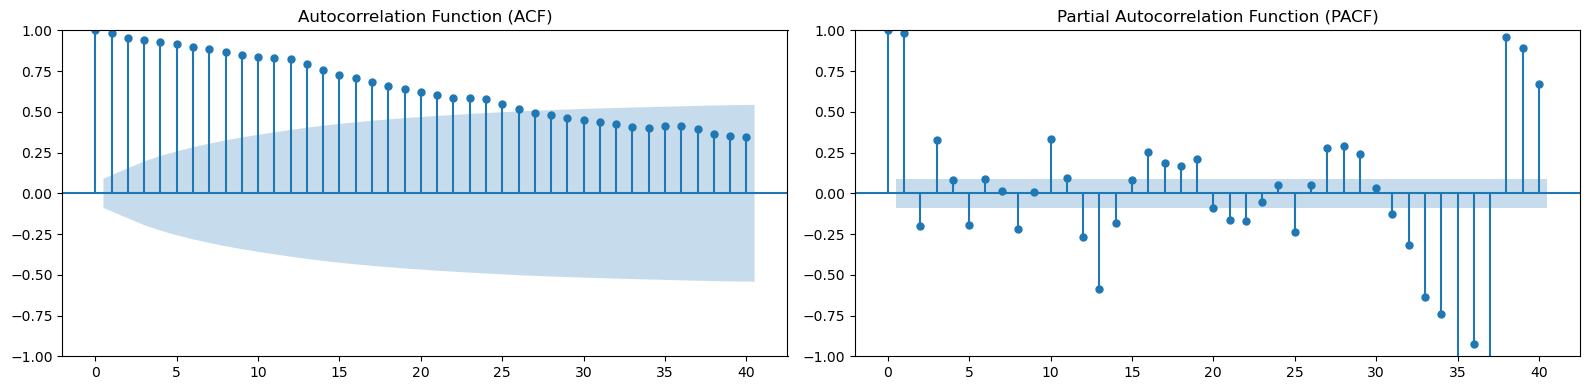

In [42]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(1, 2, figsize=(16, 4))

# Plot ACF
plot_acf(df_unemployment['Unemployment Rate'], ax=ax[0], lags=40, title='Autocorrelation Function (ACF)')

# Plot PACF
plot_pacf(df_unemployment['Unemployment Rate'], ax=ax[1], lags=40, title='Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()


In [43]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit the SARIMA model
sarima_model = SARIMAX(df_unemployment['Unemployment Rate'], order=(1, 1, 2), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit(disp=False)

# Predict using the SARIMA model
sarima_prediction = sarima_fit.fittedvalues

# Calculate the Mean Squared Error (MSE) for the SARIMA model
sarima_mse = mean_squared_error(df_unemployment['Unemployment Rate'], sarima_prediction)

sarima_mse

0.1382336170428334

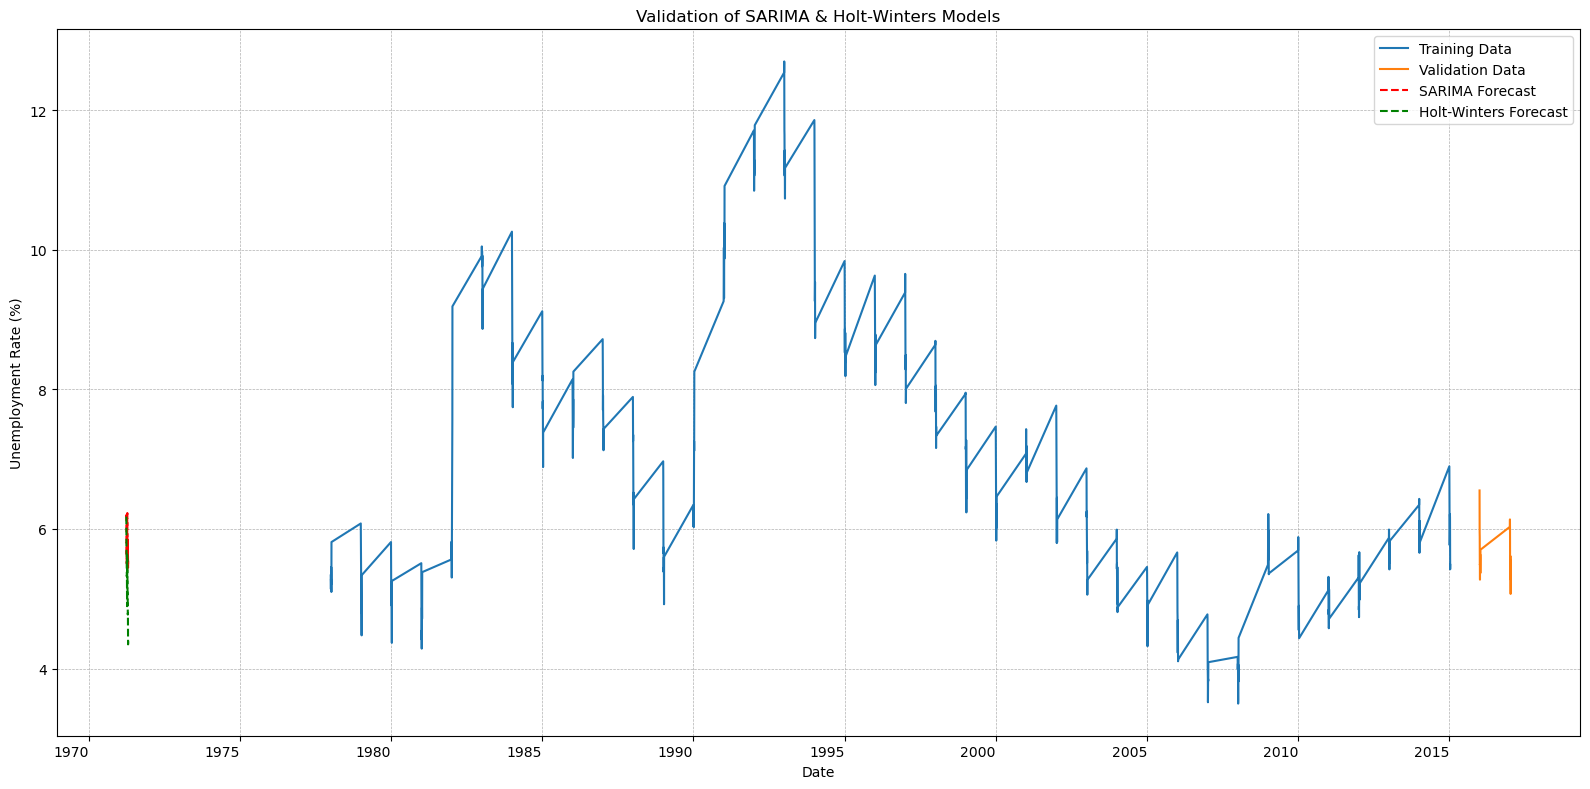

(0.061110315886429435, 0.24848262161614065)

In [44]:
import matplotlib.pyplot as plt

# Splitting the data into training and validation sets
train = df_unemployment['Unemployment Rate'][:-24]
validate = df_unemployment['Unemployment Rate'][-24:]

# Fit SARIMA model on training data
sarima_train_model = SARIMAX(train, order=(1, 1, 2), seasonal_order=(1, 1, 1, 12))
sarima_train_fit = sarima_train_model.fit(disp=False)
sarima_forecast = sarima_train_fit.forecast(steps=24)

# Fit Holt-Winters model on training data
holt_winters_train_model = ExponentialSmoothing(train, trend='additive', seasonal='additive', seasonal_periods=12)
holt_winters_train_fit = holt_winters_train_model.fit()
holt_winters_forecast = holt_winters_train_fit.forecast(steps=24)

# Calculate MSE for both models on the validation set
sarima_mse_validate = mean_squared_error(validate, sarima_forecast)
holt_winters_mse_validate = mean_squared_error(validate, holt_winters_forecast)

# Plot original series, SARIMA forecast, and Holt-Winters forecast for visual comparison
plt.figure(figsize=(16, 8))
train.plot(label='Training Data', legend=True)
validate.plot(label='Validation Data', legend=True)
sarima_forecast.plot(label='SARIMA Forecast', legend=True, color='red', linestyle='dashed')
holt_winters_forecast.plot(label='Holt-Winters Forecast', legend=True, color='green', linestyle='dashed')
plt.title('Validation of SARIMA & Holt-Winters Models')
plt.ylabel('Unemployment Rate (%)')
plt.xlabel('Date')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

sarima_mse_validate, holt_winters_mse_validate
